# Friends Classification Text (LSTM) - 5 -2

This is classification of dialogue in FRIENDS TV Series.

text (the character scipt + "as respond to"-script) + place + interlocutors --> season 7,8 as train

<!-- https://stackoverflow.com/questions/61000500/tensorflow-keras-bert-multiclass-text-classification-accuracy -->

In [1]:
import pandas as pd
import re
import numpy as np
import time

import os
import pprint
import tensorflow as tf

import sys
sys.path.insert(1, '../../src/all_functions/')

from text_tools import *

import keras
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.models import load_model

from keras.layers import Embedding, LSTM
import matplotlib.pyplot as plt
from keras import Sequential

from keras import backend as K
from keras import layers

from sklearn.preprocessing import OneHotEncoder


from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)

import matplotlib.pyplot as plt
import seaborn as sns

# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# help(drive.mount)

In [3]:
def encode(text):
    token_ids = []
    for word in text:
        try:
            token_ids.append(word2idx[word])
        except:
            token_ids.append(1)
            
    token_ids = np.array(token_ids)
    return token_ids

def set_fix_length(ids, max_len = 15):
    # print(ids)
    length = ids.shape[0]
    zeros = np.zeros(max_len)

    if length <= max_len:
        zeros[:length] = ids
    else:
        zeros = ids[:max_len]

    return zeros

In [4]:
# PATH_DATA = 'gdrive/'
PATH_DATA = '../../data/'

In [5]:
os.listdir(PATH_DATA)

['friends_seen_season_new.csv',
 'friends_unseen_season.csv',
 'friends-transcripts',
 'friends_all_dialogue.csv',
 '.DS_Store',
 'friends_all_dialogue_semi_cln.csv',
 'friends_unseen_season2_2.csv',
 'friends_unseen_season_1.csv',
 'friends_seen_season2_2.csv',
 'friends-transcripts-extract',
 'friends_seen_season2_new.csv',
 'friends_unseen_season_new.csv',
 'friends_seen_season.csv',
 'friends_all_dialogue_semi_cln2.csv',
 'friends_unseen_season2_new.csv',
 '.ipynb_checkpoints',
 'friends_seen_season2.csv',
 'friends_unseen_season2.csv',
 'friends_seen_season_1.csv']

## Importing Data

In [6]:
# %cd gdrive/My Drive/Repository/Data/

In [7]:
# os.listdir()

In [8]:
# df_dlg_seen = pd.read_csv(PATH_DATA+'friends_seen_season2.csv')
# df_dlg_unseen = pd.read_csv(PATH_DATA+'friends_unseen_season2.csv')

df_dlg_seen = pd.read_csv(PATH_DATA+'friends_seen_season2_2.csv')
df_dlg_unseen = pd.read_csv(PATH_DATA+'friends_unseen_season2_2.csv')

/Users/alamhanz/anaconda/envs/joko/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
df_dlg_seen.rename(columns = {'label_place':'places'},inplace=True)
df_dlg_unseen.rename(columns = {'label_place':'places'},inplace=True)

In [10]:
df_dlg_seen.head()

,eps,dialogue_ids,scenes_places,places,label_str,label,season,dialogue,text2,len_dialogue5,is_null2,ids,is_train,text1,label_prev,label_str_prev,is_null2_prev
0,0101,1,[central perk],1,joey,5,1,"c'mon, you're going out with the guy! there'...",c'mon you're going out with the guy there's go...,14,False,1,False,there's nothing to tell he's just some guy i w...,3.0,monica,False
1,0101,2,[central perk],1,chandler,4,1,"all right joey, be nice. so does he have a...",all right joey be nice so does he have a hump ...,16,False,2,True,c'mon you're going out with the guy there's go...,5.0,joey,False
2,0101,3,[central perk],1,phoebe,6,1,"wait, does he eat chalk? (they all stare, be...",wait does he eat chalk,5,False,3,False,all right joey be nice so does he have a hump ...,4.0,chandler,False
3,0101,5,[central perk],1,monica,3,1,"okay, everybody relax. this is not even a da...",okay everybody relax this is not even a date i...,21,False,5,True,just because i don't want her to go through wh...,6.0,phoebe,False
4,0101,6,[central perk],1,chandler,4,1,sounds like a date to me. [time lapse],sounds like a date to me,6,False,6,True,okay everybody relax this is not even a date i...,3.0,monica,False


In [11]:
df_dlg_seen.label.unique()

array([5, 4, 6, 3, 0, 2, 1])

In [12]:
# df_dlg_seen_1 = df_dlg_seen[df_dlg_seen.season.isin([8,7,6])]
# df_dlg_seen_2 = df_dlg_seen[df_dlg_seen.season.isin([5,4])&df_dlg_seen.label.isin([6,5])].sample(800, random_state=123)
# df_dlg_seen = pd.concat([df_dlg_seen_1,df_dlg_seen_2])

df_dlg_seen = df_dlg_seen[df_dlg_seen.season.isin([8,7])]

In [13]:
data_train = df_dlg_seen[(df_dlg_seen.is_train == True)&(df_dlg_seen.label!=0)][['text1','text2','label_prev','places','season','label']]
data_train['label'] = data_train['label']-1
data_train = data_train[~(data_train.text1.isnull())]

data_test = df_dlg_seen[(df_dlg_seen.is_train == False)&(df_dlg_seen.label!=0)][['text1','text2','label_prev','places','season','label']]
data_test['label'] = data_test['label']-1
data_test = data_test[~(data_test.text1.isnull())]

data_unseen = df_dlg_unseen[(df_dlg_unseen.label!=0)][['text1','text2','label_prev','places','season','label']]
data_unseen['label'] = data_unseen['label']-1
data_unseen = data_unseen[~(data_unseen.text1.isnull())]

In [14]:
data_train.shape

(6733, 6)

In [15]:
data_test.shape

(2308, 6)

In [16]:
data_unseen.shape

(8305, 6)

In [17]:
XX = data_train.label.value_counts()
XX/XX.sum()

0    0.205555
4    0.173771
1    0.164860
2    0.164414
3    0.147186
5    0.144215
Name: label, dtype: float64

In [18]:
XX = data_unseen.label.value_counts()
XX/XX.sum()

1    0.180253
0    0.169777
3    0.168694
2    0.164840
4    0.163757
5    0.152679
Name: label, dtype: float64

## Tokenizer

In [19]:
MAX_LEN = 20
EMBED_SIZE = 128

In [20]:
OH = OneHotEncoder()
OH_people = OneHotEncoder()
OH_place = OneHotEncoder()

In [21]:
data_train.head()

,text1,text2,label_prev,places,season,label
30335,david crane marta kauffman,what's going on,0.0,2,7,1
30336,i found a note on my door come to monica's qui...,i'll take that,2.0,2,7,4
30337,i'll take that,what's up,5.0,2,7,1
30338,what's up,monica and i are engaged,2.0,2,7,3
30340,where is she,i'm engaged i'm engaged,2.0,2,7,2


In [22]:
data_test.head()

,text1,text2,label_prev,places,season,label
30339,monica and i are engaged,my god congratulations,4.0,2,7,1
30341,i'm engaged i'm engaged,yeah she's been out there for twenty minutes i...,3.0,2,7,4
30347,okay wait wait wait shhh okay umm i just wanna...,it's okay i want this to be your night too to ...,3.0,2,7,3
30356,but i i i can't stay too long i gotta get up e...,so when you said get up early did you mean 1986,5.0,2,7,3
30358,you guys don't think i look 19,oh 19 we thought you said 90,5.0,2,7,5


In [23]:
data_unseen.head()

,text1,text2,label_prev,places,season,label
0,so uh i guess we should make it official huh,uh look rach hey ross is here hey look it's my...,1.0,2,9,4
1,uh look rach hey ross is here hey look it's my...,joey you,5.0,2,9,1
2,joey you,you,2.0,2,9,0
3,you,hey and look he brought flowers thanks ross bu...,1.0,2,9,4
4,hey and look he brought flowers thanks ross bu...,you're weird today listen i uh wanted to talk ...,5.0,2,9,1


In [24]:
get_ids = pd.concat([data_train,data_test])
get_ids = pd.DataFrame(get_ids['text1'].tolist()+get_ids['text2'].tolist(),columns = ['text'])

In [25]:
word2idx, idx2word = data_text_prep(get_ids)

In [26]:
VOCAB_SIZE = len(word2idx)
VOCAB_SIZE

6020

In [27]:
get_ids = pd.concat([data_train,data_test])
OH.fit(get_ids['label'].values.reshape(len(get_ids),-1))
OH_people.fit(get_ids['label_prev'].values.reshape(len(get_ids),-1))
OH_place.fit(get_ids['places'].values.reshape(len(get_ids),-1))

OneHotEncoder()

In [28]:
def get_input(df):
    X1 = []
    X2 = []
    f1 = []
    f2 = []
    f3 = []
    
    label_ls = []
    for txt1,txt2,label1,label2,label3,label in df.values:
        text_encode = encode(txt1)
        text_encode = set_fix_length(text_encode,max_len=MAX_LEN)
        X1.append(text_encode)
        
        text_encode = encode(txt2)
        text_encode = set_fix_length(text_encode,max_len=MAX_LEN)
        X2.append(text_encode)
        
        f1.append(int(label1))
        f2.append(int(label2))
        label_ls.append(label)
    
    Xf1 = OH_people.transform(np.array(f1).reshape(len(f1),-1)).toarray()
    Xf2 = OH_place.transform(np.array(f2).reshape(len(f1),-1)).toarray()
    
    X3 = np.concatenate([Xf1,Xf2],axis = 1)
    
    return np.stack(X1),np.stack(X2),np.array(X3),np.array(label_ls)

In [29]:
X_train1,X_train2,X_train3,label_train = get_input(data_train)
X_test1,X_test2,X_test3,label_test = get_input(data_test)
X_unseen1,X_unseen2,X_unseen3,label_unseen = get_input(data_unseen)

In [30]:
X_train1.shape,X_train2.shape,X_train3.shape

((6733, 20), (6733, 20), (6733, 20))

In [31]:
X_unseen1.shape,X_unseen2.shape,X_unseen3.shape

((8305, 20), (8305, 20), (8305, 20))

In [32]:
y_train = OH.transform(label_train.reshape(len(label_train),-1)).toarray()
y_test = OH.transform(label_test.reshape(len(label_test),-1)).toarray()
y_unseen = OH.transform(label_unseen.reshape(len(label_unseen),-1)).toarray()

In [33]:
X_train3.shape

(6733, 20)

## Training Model

In [34]:
def text_net() :
    # sentence_indices = keras.Input(25, dtype = 'int32')
    mod1 = Sequential()
    mod1.add(Embedding(VOCAB_SIZE, EMBED_SIZE))
    mod1.add(LSTM(128,return_sequences = True))
    mod1.add(LSTM(64,return_sequences = True))
    mod1.add(layers.Dropout(0.4))
    return mod1

In [35]:
input_dim_txt = (MAX_LEN)
txt_1 = keras.Input(shape=input_dim_txt)
txt_2 = keras.Input(shape=input_dim_txt)
inp_3 = keras.Input(shape=(20))

In [36]:
tx_net = text_net()
connect_layer = layers.Concatenate(axis=2)
connect_layer2 = layers.Concatenate(axis=1)

feat_txt_1 = tx_net(txt_1)
feat_txt_2 = tx_net(txt_2)

concat_txt = connect_layer([feat_txt_1, feat_txt_2])
inp_3_emb = layers.Dense(128,activation='relu')(inp_3)
inp_3_emb = layers.Dense(128,activation='relu')(inp_3_emb)
inp_3_emb = layers.Dense(64,activation='relu')(inp_3_emb)
inp_3_emb = layers.Dense(16,activation='relu')(inp_3_emb)

LSTM_2 = LSTM(64,return_sequences = True)(concat_txt)
LSTM_2 = LSTM(16,return_sequences = True)(LSTM_2)
layers_n = layers.Flatten()(LSTM_2)
layers_n = layers.Dense(256,activation='relu')(layers_n)
layers_n = layers.Dropout(0.2)(layers_n)
layers_n = layers.Dense(16,activation='relu')(layers_n)
layers_n = connect_layer2([layers_n, inp_3_emb])

layers_n = layers.Dense(32,activation='relu')(layers_n)
layers_n = layers.Dense(32,activation='relu')(layers_n)
layers_n = layers.Dropout(0.2)(layers_n)
prediction = layers.Dense(6,activation='softmax')(layers_n)

mod1 = keras.Model(inputs = [txt_1, txt_2, inp_3], outputs = prediction)

In [37]:
mod1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, 64)     951552      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 20, 128)      0           sequential[0][0]      

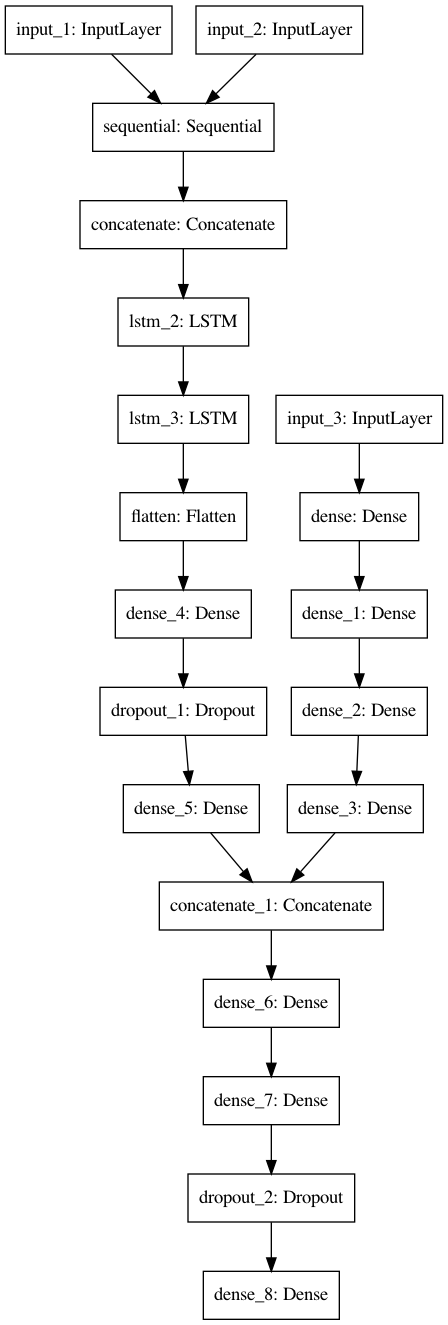

In [38]:
keras.utils.plot_model(mod1)

In [39]:
filepath = '../../models/simple_LSTM5-2/model_{epoch:02d}_{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

In [40]:
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
LR = 5e-4
EPOCHS = 40
BATCH_SIZE = 25
opt = keras.optimizers.Adam(learning_rate=LR)
mod1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

mod_history = mod1.fit([X_train1,X_train2,X_train3], y_train, 
            validation_data=([X_test1,X_test2,X_test3], y_test), 
            epochs=EPOCHS, batch_size = BATCH_SIZE, verbose=1,
            callbacks=[checkpoint])

Epoch 1/40
269/270 [============================>.] - ETA: 0s - loss: 1.7053 - accuracy: 0.2833
Epoch 00001: val_accuracy improved from -inf to 0.32799, saving model to ../../models/simple_LSTM5-2/model_01_0.33.hdf5
270/270 [==============================] - 21s 78ms/step - loss: 1.7054 - accuracy: 0.2831 - val_loss: 1.6107 - val_accuracy: 0.3280
Epoch 2/40
269/270 [============================>.] - ETA: 0s - loss: 1.5747 - accuracy: 0.3625
Epoch 00002: val_accuracy improved from 0.32799 to 0.36828, saving model to ../../models/simple_LSTM5-2/model_02_0.37.hdf5
270/270 [==============================] - 18s 68ms/step - loss: 1.5745 - accuracy: 0.3625 - val_loss: 1.5163 - val_accuracy: 0.3683
Epoch 3/40
269/270 [============================>.] - ETA: 0s - loss: 1.4999 - accuracy: 0.4000
Epoch 00003: val_accuracy improved from 0.36828 to 0.42721, saving model to ../../models/simple_LSTM5-2/model_03_0.43.hdf5
270/270 [==============================] - 18s 67ms/step - loss: 1.5001 - accura

## Testing

In [41]:
mod_use = keras.models.load_model('../../models/simple_LSTM5-2/model_24_0.44.hdf5')

In [42]:
def plot_cm(labels, predictions, type_eval = 'test'):
    cm = confusion_matrix(labels, predictions)
    cm = (cm.transpose()/cm.sum(axis = 1)).transpose()
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt=".2%")
    plt.title("Confusion matrix ("+type_eval+") - 5_2")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")

In [43]:
y_pred_test = mod_use.predict([X_test1,X_test2,X_test3])
y_pred_test = np.argmax(y_pred_test,axis = 1)
y_true_test = np.argmax(y_test,axis = 1)

              precision    recall  f1-score   support

           0       0.42      0.50      0.46       439
           1       0.42      0.39      0.40       426
           2       0.43      0.56      0.49       372
           3       0.42      0.51      0.46       343
           4       0.53      0.40      0.46       383
           5       0.40      0.26      0.31       345

    accuracy                           0.44      2308
   macro avg       0.44      0.43      0.43      2308
weighted avg       0.44      0.44      0.43      2308



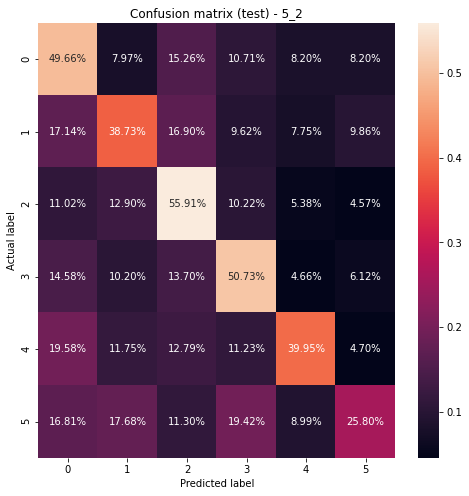

In [44]:
report = classification_report(y_true_test,y_pred_test)
print(report)
plot_cm(y_true_test,y_pred_test, type_eval = 'test')

In [45]:
y_pred = mod_use.predict([X_unseen1,X_unseen2,X_unseen3])
y_pred_label = np.argmax(y_pred,axis = 1)
y_true_label = data_unseen['label'].values

              precision    recall  f1-score   support

           0       0.28      0.36      0.32      1410
           1       0.32      0.35      0.34      1497
           2       0.41      0.48      0.44      1369
           3       0.44      0.47      0.45      1401
           4       0.37      0.22      0.28      1360
           5       0.30      0.23      0.26      1268

    accuracy                           0.35      8305
   macro avg       0.35      0.35      0.35      8305
weighted avg       0.35      0.35      0.35      8305



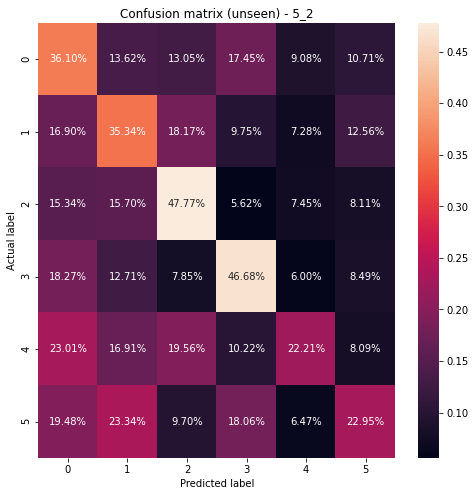

In [46]:
report = classification_report(y_true_label, y_pred_label)
print(report)
plot_cm(y_true_label, y_pred_label,type_eval = 'unseen')